In [1]:
import numpy as np
import scipy.stats as ss
import elfi
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
from pyabc.examples import clinic
from pyabc.utils import plot_marginals

warning in stationary: failed to import cython module: falling back to numpy


 /home/michael/work/git/acm2017_abc/pyabc/__init__.py:3: UserWarning:
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/michael/anaconda3/envs/elfi/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/michael/anaconda3/envs/elfi/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/michael/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/michael/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/michael/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    io

# Clinic Example
![](img/clinic.png)

In [2]:
simulator = clinic.simulator

In [3]:
# Set the generating parameters that we will try to infer
lambda0 = 1/10

# Generate some dat9 (using a fixed seed here)
np.random.seed(1228)
y0 = simulator(lambda0)
print(y0)

[[49], array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.42344354,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   4.51585521,   0.        ,
         4.34929369,   5.33611555,   4.79045358,  11.19269357,
        10.47966238,   6.52416327,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   5.97595535,   8.83547883,
         0.        ,   0.        ,   0.        ,   0.29101362,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,   0.        ]), [964.8378133280579]]


In [4]:
closing_time, nr_patients, nr_waiting_patients = clinic.summaries

In [5]:
# prior over rate parameter
rate = pyabc.Prior('uniform', 0.01,1, name='rate')
rate.name

'rate'

# Our PYABC

In [6]:
rej = pyabc.RejectionSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [7]:
rej.sample(nr_samples=1000, threshold=0.01)

Rejection sampler started with threshold: 0.01 and number of samples: 1000
Samples:   1000 - Threshold: 0.01 - Iterations:      25000 - Acceptance rate: 0.040000 - Time:    25.32 s


In [8]:
smc = pyabc.SMCSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [9]:
smc.sample(nr_samples=1000, thresholds=[0.1, 0.05, 0.01])

SMC sampler started with thresholds: [0.1, 0.05, 0.01] and number of samples: 1000
Rejection sampler started with threshold: 0.1 and number of samples: 1000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
Samples:   1000 - Thresholds: 0.01 - Iterations:      12837 - Acceptance rate: 0.077900 - Time:    12.18 s


In [10]:
smc.Thetas

array([[ 0.10164908],
       [ 0.11056871],
       [ 0.13299987],
       [ 0.10982465],
       [ 0.09681621],
       [ 0.09897009],
       [ 0.11842131],
       [ 0.12156442],
       [ 0.095492  ],
       [ 0.11731493],
       [ 0.10655176],
       [ 0.10876874],
       [ 0.10620712],
       [ 0.14101257],
       [ 0.10014378],
       [ 0.10342709],
       [ 0.13879226],
       [ 0.09301717],
       [ 0.10944543],
       [ 0.14064327],
       [ 0.14234831],
       [ 0.1060603 ],
       [ 0.09122242],
       [ 0.10855789],
       [ 0.11919001],
       [ 0.15316368],
       [ 0.13831188],
       [ 0.12120811],
       [ 0.12600812],
       [ 0.13912393],
       [ 0.15864626],
       [ 0.12076886],
       [ 0.13747211],
       [ 0.10013714],
       [ 0.1224864 ],
       [ 0.11300218],
       [ 0.15004315],
       [ 0.09124598],
       [ 0.13878823],
       [ 0.10014257],
       [ 0.12388792],
       [ 0.11514128],
       [ 0.13403777],
       [ 0.13659585],
       [ 0.1346673 ],
       [ 0

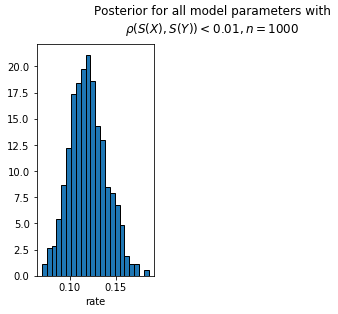

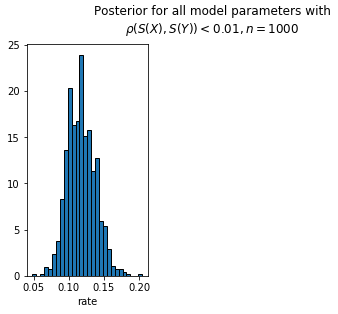

In [12]:
plot_marginals(rej)
plot_marginals(smc)